# Build a Question/Answering system over SQL data

:::info Prerequisites

This guide assumes familiarity with the following concepts:

- [Chaining runnables](/docs/how_to/sequence/)
- [Chat models](/docs/concepts/#chat-models)
- [Tools](/docs/concepts/#tools)
- [Agents](/docs/concepts/#agents)

:::

Enabling a LLM system to query structured data can be qualitatively different from unstructured text data. Whereas in the latter it is common to generate text that can be searched against a vector database, the approach for structured data is often for the LLM to write and execute queries in a DSL, such as SQL. In this guide we'll go over the basic ways to create a Q&A system over tabular data in databases. We will cover implementations using both chains and agents. These systems will allow us to ask a question about the data in a database and get back a natural language answer. The main difference between the two is that our agent can query the database in a loop as many times as it needs to answer the question.

## ⚠️ Security note ⚠️

Building Q&A systems of SQL databases requires executing model-generated SQL queries. There are inherent risks in doing this. Make sure that your database connection permissions are always scoped as narrowly as possible for your chain/agent's needs. This will mitigate though not eliminate the risks of building a model-driven system. For more on general security best practices, [see here](/docs/security).


## Architecture

At a high-level, the steps of these systems are:

1. **Convert question to DSL query**: Model converts user input to a SQL query.
2. **Execute SQL query**: Execute the query.
3. **Answer the question**: Model responds to user input using the query results.

Note that querying data in CSVs can follow a similar approach. See our [how-to guide](/docs/how_to/sql_csv) on question-answering over CSV data for more detail.

![sql_usecase.png](../../static/img/sql_usecase.png)

## Setup

First, get required packages and set environment variables:

In [1]:
# %%capture --no-stderr
# %pip install --upgrade --quiet langchain langchain-community langchain-openai faiss-cpu

We will use an OpenAI model and a [FAISS-powered vector store](/docs/integrations/vectorstores/faiss/) in this guide.

In [58]:
import ast
import re
from operator import itemgetter

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain import hub
from langchain.agents.agent_toolkits import create_retriever_tool
from langchain.chains import create_sql_query_chain
from langchain_community.agent_toolkits import (
    SparkSQLToolkit,
    SQLDatabaseToolkit,
    create_spark_sql_agent,
)
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_community.utilities import SQLDatabase
from langchain_community.utilities.spark_sql import SparkSQL
from langchain_community.vectorstores import FAISS
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import (
    ChatPromptTemplate,
    FewShotPromptTemplate,
    MessagesPlaceholder,
    PromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.prebuilt import create_react_agent

In [59]:
load_dotenv()

True

In [60]:
# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0)

The below example will use a SQLite connection with Chinook database. Follow [these installation steps](https://database.guide/2-sample-databases-sqlite/) to create `Chinook.db` in the same directory as this notebook:

* Save [this file](https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql) as `Chinook.sql`
* Run `sqlite3 Chinook.db`
* Run `.read Chinook.sql`
* Test `SELECT * FROM Artist LIMIT 10;`

Now, `Chinhook.db` is in our directory and we can interface with it using the SQLAlchemy-driven `SQLDatabase` class:

# SQLite

In [4]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

Great! We've got a SQL database that we can query. Now let's try hooking it up to an LLM.

## Chains {#chains}

Chains (i.e., compositions of LangChain [Runnables](/docs/concepts#langchain-expression-language-lcel)) support applications whose steps are predictable. We can create a simple chain that takes a question and does the following:
- convert the question into a SQL query;
- execute the query;
- use the result to answer the original question.

There are scenarios not supported by this arrangement. For example, this system will execute a SQL query for any user input-- even "hello". Importantly, as we'll see below, some questions require more than one query to answer. We will address these scenarios in the Agents section.

### Convert question to SQL query

The first step in a SQL chain or agent is to take the user input and convert it to a SQL query. LangChain comes with a built-in chain for this: [create_sql_query_chain](https://python.langchain.com/v0.2/api_reference/langchain/chains/langchain.chains.sql_database.query.create_sql_query_chain.html).

```{=mdx}
import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />
```

In [61]:
# | output: false
# | echo: false

In [8]:
chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "How many employees are there"})
print(response)

```sql
SQLQuery: SELECT COUNT("EmployeeId") AS "NumberOfEmployees" FROM "Employee"


In [9]:
response.split(":")[-1].strip()

'SELECT COUNT("EmployeeId") AS "NumberOfEmployees" FROM "Employee"'

We can execute the query to make sure it's valid:

In [10]:
db.run(response.split(":")[-1].strip())

'[(8,)]'

We can look at the [LangSmith trace](https://smith.langchain.com/public/c8fa52ea-be46-4829-bde2-52894970b830/r) to get a better understanding of what this chain is doing. We can also inspect the chain directly for its prompts. Looking at the prompt (below), we can see that it is:

* Dialect-specific. In this case it references SQLite explicitly.
* Has definitions for all the available tables.
* Has three examples rows for each table.

This technique is inspired by papers like [this](https://arxiv.org/pdf/2204.00498.pdf), which suggest showing examples rows and being explicit about tables improves performance. We can also inspect the full prompt like so:

In [11]:
chain.get_prompts()[0].pretty_print()

You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result

### Execute SQL query

Now that we've generated a SQL query, we'll want to execute it. **This is the most dangerous part of creating a SQL chain.** Consider carefully if it is OK to run automated queries over your data. Minimize the database connection permissions as much as possible. Consider adding a human approval step to you chains before query execution (see below).

We can use the `QuerySQLDatabaseTool` to easily add query execution to our chain:

In [12]:
def get_exact_query(text: str) -> str:
    return text.split(":")[-1].strip()


execute_query = QuerySQLDataBaseTool(db=db)
write_query = create_sql_query_chain(llm, db) | RunnableLambda(get_exact_query)
chain = write_query | execute_query
chain.invoke({"question": "How many employees are there"})

'[(8,)]'

### Answer the question

Now that we've got a way to automatically generate and execute queries, we just need to combine the original question and SQL query result to generate a final answer. We can do this by passing question and result to the LLM once more:

In [13]:
answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQL query, and SQL result, answer the user question.

Question: {question}
SQL Query: {query}
SQL Result: {result}
Answer: """
)

chain = (
    RunnablePassthrough.assign(query=write_query).assign(
        result=itemgetter("query") | execute_query
    )
    | answer_prompt
    | llm
    | StrOutputParser()
)

chain.invoke({"question": "How many employees are there"})

'There are 8 employees.'

Let's review what is happening in the above LCEL. Suppose this chain is invoked.
- After the first `RunnablePassthrough.assign`, we have a runnable with two elements:  
  `{"question": question, "query": write_query.invoke(question)}`  
  Where `write_query` will generate a SQL query in service of answering the question.
- After the second `RunnablePassthrough.assign`, we have add a third element `"result"` that contains `execute_query.invoke(query)`, where `query` was computed in the previous step.
- These three inputs are formatted into the prompt and passed into the LLM.
- The `StrOutputParser()` plucks out the string content of the output message.

Note that we are composing LLMs, tools, prompts, and other chains together, but because each implements the Runnable interface, their inputs and outputs can be tied together in a reasonable way.

### Next steps

For more complex query-generation, we may want to create few-shot prompts or add query-checking steps. For advanced techniques like this and more check out:

* [Prompting strategies](/docs/how_to/sql_prompting): Advanced prompt engineering techniques.
* [Query checking](/docs/how_to/sql_query_checking): Add query validation and error handling.
* [Large databses](/docs/how_to/sql_large_db): Techniques for working with large databases.

## Agents {#agents}

LangChain has a SQL Agent which provides a more flexible way of interacting with SQL Databases than a chain. The main advantages of using the SQL Agent are:

- It can answer questions based on the databases' schema as well as on the databases' content (like describing a specific table).
- It can recover from errors by running a generated query, catching the traceback and regenerating it correctly.
- It can query the database as many times as needed to answer the user question.
- It will save tokens by only retrieving the schema from relevant tables.

To initialize the agent we'll use the `SQLDatabaseToolkit` to create a bunch of tools:

* Create and execute queries
* Check query syntax
* Retrieve table descriptions
* ... and more

In [14]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(tool.name, end="\n\n")

sql_db_query

sql_db_schema

sql_db_list_tables

sql_db_query_checker



### System Prompt

We will also want to create a system prompt for our agent. This will consist of instructions for how to behave.

In [31]:
sql_prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(sql_prompt_template.messages) == 1

In [32]:
print(sql_prompt_template.input_variables)
print(sql_prompt_template.messages)
print(sql_prompt_template.pretty_print())

['dialect', 'top_k']
[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['dialect', 'top_k'], input_types={}, partial_variables={}, template='You are an agent designed to interact with a SQL database.\nGiven an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.\nUnless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.\nYou can order the results by a relevant column to return the most interesting examples in the database.\nNever query for all the columns from a specific table, only ask for the relevant columns given the question.\nYou have access to tools for interacting with the database.\nOnly use the below tools. Only use the information returned by the below tools to construct your final answer.\nYou MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and t

In [35]:
sql_messages = sql_prompt_template.invoke(
    {
        "dialect": "T-SQL",
        "top_k": 5,
    }
)
sql_system_message = sql_messages.messages[0]
print(sql_system_message.content)

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct T-SQL query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you c

In [36]:
SQL_PREFIX = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables."""

system_message = SystemMessage(content=SQL_PREFIX)
print(system_message.content)

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you 

### Initializing agent
First, get required package **LangGraph**

In [37]:
# %%capture --no-stderr
# %pip install --upgrade --quiet langgraph

We will use a prebuilt [LangGraph](/docs/concepts/#langgraph) agent to build our agent

In [38]:
agent_executor = create_react_agent(llm, tools, state_modifier=system_message)

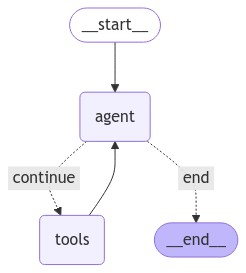

In [39]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

Consider how the agent responds to the below question:

In [40]:
for s in agent_executor.stream(
    {"messages": [HumanMessage(content="Which country's customers spent the most?")]}
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3iFyMg9DDX3hixXdFrPfl2Zx', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 548, 'total_tokens': 560, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7568d46099', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-314ab29a-5cc2-4fac-afd0-c3cdb0273d58-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_3iFyMg9DDX3hixXdFrPfl2Zx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 548, 'output_tokens': 12, 'total_tokens': 560})]}}
----
{'tools': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', tool_call_id='call_3iFyMg9DDX3hixXdFrPfl2Zx')]}}
----
{'agent

Note that the agent executes multiple queries until it has the information it needs:
1. List available tables;
2. Retrieves the schema for three tables;
3. Queries multiple of the tables via a join operation.

The agent is then able to use the result of the final query to generate an answer to the original question.

The agent can similarly handle qualitative questions:

In [41]:
for s in agent_executor.stream(
    {"messages": [HumanMessage(content="Describe the playlisttrack table")]}
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NRRQtOW112yx4zb7aPIKc7sC', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 546, 'total_tokens': 558, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7568d46099', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e4623dc9-1e92-4af7-ad1f-dfbbbd2db970-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'call_NRRQtOW112yx4zb7aPIKc7sC', 'type': 'tool_call'}], usage_metadata={'input_tokens': 546, 'output_tokens': 12, 'total_tokens': 558})]}}
----
{'tools': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', tool_call_id='call_NRRQtOW112yx4zb7aPIKc7sC')]}}
----
{'agent

### Dealing with high-cardinality columns

In order to filter columns that contain proper nouns such as addresses, song names or artists, we first need to double-check the spelling in order to filter the data correctly. 

We can achieve this by creating a vector store with all the distinct proper nouns that exist in the database. We can then have the agent query that vector store each time the user includes a proper noun in their question, to find the correct spelling for that word. In this way, the agent can make sure it understands which entity the user is referring to before building the target query.

First we need the unique values for each entity we want, for which we define a function that parses the result into a list of elements:

In [42]:
def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['Meus Momentos',
 'Bach: Goldberg Variations',
 'Achtung Baby',
 'Worlds',
 'Szymanowski: Piano Works, Vol.']

Using this function, we can create a **retriever tool** that the agent can execute at its discretion.

In [43]:
vector_db = FAISS.from_texts(
    artists + albums, OpenAIEmbeddings(model="text-embedding-3-small")
)
retriever = vector_db.as_retriever(search_kwargs={"k": 5})
description = """Use to look up values to filter on. Input is an approximate spelling of the proper noun, output is \
valid proper nouns. Use the noun most similar to the search."""
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

Let's try it out:

In [44]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Whitesnake

Pearl Jam

Pearl Jam

Alanis Morissette


This way, if the agent determines it needs to write a filter based on an artist along the lines of "Alice Chains", it can first use the retriever tool to observe relevant values of a column.

Putting this together:

In [45]:
system = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

You have access to the following tables: {table_names}

If you need to filter on a proper noun, you must ALWAYS first look up the filter value using the "search_proper_nouns" tool!
Do not try to guess at the proper name - use this function to find similar ones.""".format(
    table_names=db.get_usable_table_names()
)

system_message = SystemMessage(content=system)

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, state_modifier=system_message)

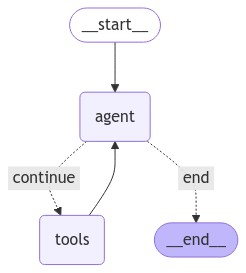

In [46]:
display(Image(agent.get_graph().draw_mermaid_png()))

In [47]:
for s in agent.stream(
    {"messages": [HumanMessage(content="How many albums does alis in chain have?")]}
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1IEjRiGhtGL2urBSzOn2Z4zr', 'function': {'arguments': '{"query":"alis in chain"}', 'name': 'search_proper_nouns'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 665, 'total_tokens': 684, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7568d46099', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5953c79a-c7e4-4acb-b181-a557d4f1c86e-0', tool_calls=[{'name': 'search_proper_nouns', 'args': {'query': 'alis in chain'}, 'id': 'call_1IEjRiGhtGL2urBSzOn2Z4zr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 665, 'output_tokens': 19, 'total_tokens': 684})]}}
----
{'tools': {'messages': [ToolMessage(content='Alice In Chains\n\nIn Step\n\nIV\n\nTransmission\n\nCoda', name='search_proper_nouns', tool_call_id='call_1IEjRiGhtGL2urBSzOn2Z4zr')]}}
----
{'agen

As we can see, the agent used the `search_proper_nouns` tool in order to check how to correctly query the database for this specific artist.

### Using a dynamic few-shot prompt

In [48]:
examples = [
    {"input": "List all artists.", "query": "SELECT * FROM Artist;"},
    {
        "input": "Find all albums for the artist 'AC/DC'.",
        "query": "SELECT * FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'AC/DC');",
    },
    {
        "input": "List all tracks in the 'Rock' genre.",
        "query": "SELECT * FROM Track WHERE GenreId = (SELECT GenreId FROM Genre WHERE Name = 'Rock');",
    },
    {
        "input": "Find the total duration of all tracks.",
        "query": "SELECT SUM(Milliseconds) FROM Track;",
    },
    {
        "input": "List all customers from Canada.",
        "query": "SELECT * FROM Customer WHERE Country = 'Canada';",
    },
    {
        "input": "How many tracks are there in the album with ID 5?",
        "query": "SELECT COUNT(*) FROM Track WHERE AlbumId = 5;",
    },
    {
        "input": "Find the total number of invoices.",
        "query": "SELECT COUNT(*) FROM Invoice;",
    },
    {
        "input": "List all tracks that are longer than 5 minutes.",
        "query": "SELECT * FROM Track WHERE Milliseconds > 300000;",
    },
    {
        "input": "Who are the top 5 customers by total purchase?",
        "query": "SELECT CustomerId, SUM(Total) AS TotalPurchase FROM Invoice GROUP BY CustomerId ORDER BY TotalPurchase DESC LIMIT 5;",
    },
    {
        "input": "Which albums are from the year 2000?",
        "query": "SELECT * FROM Album WHERE strftime('%Y', ReleaseDate) = '2000';",
    },
    {
        "input": "How many employees are there",
        "query": 'SELECT COUNT(*) FROM "Employee"',
    },
]

In [49]:
example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples,
    OpenAIEmbeddings(model="text-embedding-3-small"),
    FAISS,
    k=5,
    input_keys=["input"],
)

In [50]:
retrieved_examples = example_selector.select_examples(
    {"input": "How many artists are there?"}
)
retrieved_examples

[{'input': 'List all artists.', 'query': 'SELECT * FROM Artist;'},
 {'input': 'How many tracks are there in the album with ID 5?',
  'query': 'SELECT COUNT(*) FROM Track WHERE AlbumId = 5;'},
 {'input': 'How many employees are there',
  'query': 'SELECT COUNT(*) FROM "Employee"'},
 {'input': "Find all albums for the artist 'AC/DC'.",
  'query': "SELECT * FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'AC/DC');"},
 {'input': 'Which albums are from the year 2000?',
  'query': "SELECT * FROM Album WHERE strftime('%Y', ReleaseDate) = '2000';"}]

In [51]:
system_prefix = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don't know" as the answer.

Here are some examples of user inputs and their corresponding SQL queries:"""

In [52]:
few_shot_prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=PromptTemplate.from_template(
        "User input: {input}\nSQL query: {query}"
    ),
    input_variables=["input", "dialect", "top_k"],
    prefix=system_prefix,
    suffix="",
)

In [53]:
print(
    few_shot_prompt.format(
        input="How many artists are there?", dialect="SQLite", top_k=5
    )
)

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don't know" as

In [54]:
full_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate(prompt=few_shot_prompt),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ]
)

In [55]:
# Example formatted prompt
prompt_val = full_prompt.invoke(
    {
        "input": "How many arists are there",
        "top_k": 5,
        "dialect": "SQLite",
        "agent_scratchpad": [],
    }
)
print(prompt_val.to_string())

System: You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don't 

In [56]:
agent = create_react_agent(llm, tools, state_modifier=full_prompt)

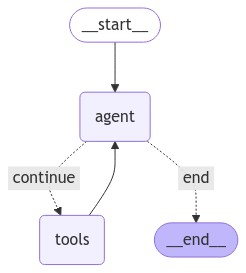

In [57]:
display(Image(agent.get_graph().draw_mermaid_png()))

# Spark

In [4]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [5]:
conf = SparkConf()
conf.set("spark.sql.sources.partitionOverwriteMode", "dynamic")
conf.set("spark.sql.sources.partitionColumnTypeInference.enabled", False)
conf.set("spark.sql.broadcastTimeout", "2400")
conf.set("spark.sql.warehouse.dir", "agent_warehouse")
conf.set(
    "spark.jars.packages",
    "io.delta:delta-spark_2.13:3.2.0,org.apache.hadoop:hadoop-azure:3.4.0",
)
conf.set("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
conf.set(
    "spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog"
)

# conf.set("hive.internal.ss.authz.settings.applied.marker", True)
# conf.set("hive.stats.jdbc.timeout", 30)
# conf.set("hive.stats.retries.wait", 3000)
# conf.set("spark.sql.catalogImplementation", "hive")

In [6]:
spark = (
    SparkSession.builder.config(conf=conf)
    .appName("spark-agent")
    .enableHiveSupport()
    .getOrCreate()
)

24/08/31 16:06:29 WARN Utils: Your hostname, MayM1.local resolves to a loopback address: 127.0.0.1; using 192.168.1.5 instead (on interface en0)
24/08/31 16:06:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/may/spark/spark-3.5.2-bin-hadoop3-scala2.13/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/may/.ivy2/cache
The jars for the packages stored in: /Users/may/.ivy2/jars
io.delta#delta-spark_2.13 added as a dependency
org.apache.hadoop#hadoop-azure added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-111d6439-4742-4381-9b70-8aec34871d98;1.0
	confs: [default]
	found io.delta#delta-spark_2.13;3.2.0 in central
	found io.delta#delta-storage;3.2.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
	found org.apache.hadoop#hadoop-azure;3.4.0 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in local-m2-cache
	found org.apache.httpcomponents#httpcore;4.4.13 in local-m2-cache
	found commons-logging#commons-logging;1.2 in local-m2-cache
	found commons-codec#commons-codec;1.15 in local-m2-cache
	found com.microsoft.azure#azure-storage;7.0.1 in central
	found com.microsoft.azure#azure-keyvault-core;1.0.0 in central
	found org.apache.hadoop.thirdparty#hadoop-shaded-guava;1.2.0 in central
	found org.ecli

In [7]:
spark.sparkContext.setLogLevel("ERROR")

In [8]:
# configurations = spark.sql("SET")
# configurations.show(truncate=False)

In [9]:
# builder = SparkSession.builder.appName("MyApp") \
#     .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
#     .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

In [10]:
# spark_session = configure_spark_with_delta_pip(builder).getOrCreate()

In [11]:
# data = spark.range(0, 5)
# data.write.format("delta").save("delta-table")

In [12]:
spark.sql("SHOW DATABASES").show()

+---------+
|namespace|
+---------+
| agent_db|
|  default|
+---------+



In [16]:
spark.sql("CREATE DATABASE IF NOT EXISTS agent_db")

DataFrame[]

In [17]:
spark.sql("SHOW DATABASES").show()

+---------+
|namespace|
+---------+
| agent_db|
|  default|
+---------+



In [18]:
spark.sql("USE agent_db")

DataFrame[]

In [19]:
spark.sql(
    """
    CREATE TABLE IF NOT EXISTS people (
        id INT,
        name STRING,
        age INT
    )
"""
)

DataFrame[]

In [20]:
spark.sql("SHOW TABLES").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
| agent_db|   people|      false|
+---------+---------+-----------+



In [21]:
spark.sql("DESCRIBE people").show()

+--------+---------+-------+
|col_name|data_type|comment|
+--------+---------+-------+
|      id|      int|   NULL|
|    name|   string|   NULL|
|     age|      int|   NULL|
+--------+---------+-------+



In [22]:
spark.sql(
    """
    INSERT INTO people VALUES
    (1, 'Alice', 25),
    (2, 'Bob', 30),
    (3, 'Charlie', 35),
    (4, 'David', 40),
    (5, 'Eve', 45)
"""
)

DataFrame[]

In [23]:
spark.sql("SELECT * FROM people").show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  4|  David| 40|
|  3|Charlie| 35|
|  5|    Eve| 45|
|  5|    Eve| 45|
|  3|Charlie| 35|
|  4|  David| 40|
|  2|    Bob| 30|
|  1|  Alice| 25|
|  1|  Alice| 25|
|  2|    Bob| 30|
+---+-------+---+



# Spark Agent

In [24]:
spark_db = SparkSQL(
    spark_session=spark,
    catalog="spark_catalog",
    schema="agent_db",
    sample_rows_in_table_info=10,
)

In [25]:
spark_toolkit = SparkSQLToolkit(db=spark_db, llm=llm)

spark_tools = spark_toolkit.get_tools()

for spark_tool in spark_tools:
    print(spark_tool.name, end="\n\n")

query_sql_db

schema_sql_db

list_tables_sql_db

query_checker_sql_db



In [26]:
spark_db.get_usable_table_names()

['people']

In [27]:
system = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SparkSQL query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

You have access to the following tables: {table_names}

If you need to filter on a proper noun, you must ALWAYS first look up the filter value using the "search_proper_nouns" tool!
Do not try to guess at the proper name - use this function to find similar ones.""".format(
    table_names=spark_db.get_usable_table_names()
)

system_message = SystemMessage(content=system)

In [28]:
spark_agent = create_react_agent(llm, spark_tools, state_modifier=system_message)

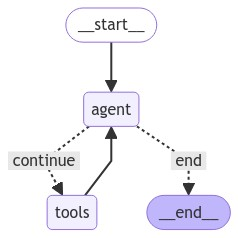

In [29]:
display(Image(spark_agent.get_graph().draw_mermaid_png()))

In [30]:
for s in spark_agent.stream(
    {"messages": [HumanMessage(content="How many people are there?")]}
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_95sTXalRfFaOOfJpmgL5VPAa', 'function': {'arguments': '{"table_names":"people"}', 'name': 'schema_sql_db'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 495, 'total_tokens': 511}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9e15ccd6a4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-82fbd795-e6ec-4a03-8130-e406bf0b6132-0', tool_calls=[{'name': 'schema_sql_db', 'args': {'table_names': 'people'}, 'id': 'call_95sTXalRfFaOOfJpmgL5VPAa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 495, 'output_tokens': 16, 'total_tokens': 511})]}}
----
{'tools': {'messages': [ToolMessage(content='CREATE TABLE agent_db.people (\n  id INT,\n  name STRING,\n  age INT)\n;\n\n/*\n10 rows from people table:\nid\tname\tage\n4\tDavid\t40\n3\tCharlie\t35\n5\tEve\t45\n5\tEve\t45\n3\tCharlie\t35\n4\tDavid\t40\n2\tBob\t

{'tools': {'messages': [ToolMessage(content="[('5',)]", name='query_sql_db', tool_call_id='call_VSbsFyAAb633edDBfuJam1V6')]}}
----
{'agent': {'messages': [AIMessage(content='There are 5 distinct people in the database.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 728, 'total_tokens': 739}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9e15ccd6a4', 'finish_reason': 'stop', 'logprobs': None}, id='run-ebea3855-0a30-4681-84d4-a63af0764435-0', usage_metadata={'input_tokens': 728, 'output_tokens': 11, 'total_tokens': 739})]}}
----


In [32]:
for s in spark_agent.stream(
    {"messages": [HumanMessage(content="How many rows of people are there?")]}
):
    print(s)
    print("----")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_twCxLVwDg118Tua6mNHw2053', 'function': {'arguments': '{"table_names":"people"}', 'name': 'schema_sql_db'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 497, 'total_tokens': 513}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbac5eb3c0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-81a333f6-4270-4bf7-99b7-76ad7bf157b4-0', tool_calls=[{'name': 'schema_sql_db', 'args': {'table_names': 'people'}, 'id': 'call_twCxLVwDg118Tua6mNHw2053', 'type': 'tool_call'}], usage_metadata={'input_tokens': 497, 'output_tokens': 16, 'total_tokens': 513})]}}
----
{'tools': {'messages': [ToolMessage(content='CREATE TABLE agent_db.people (\n  id INT,\n  name STRING,\n  age INT)\n;\n\n/*\n10 rows from people table:\nid\tname\tage\n4\tDavid\t40\n3\tCharlie\t35\n5\tEve\t45\n5\tEve\t45\n3\tCharlie\t35\n4\tDavid\t40\n2\tBob\t